<h1 align="center"> KDE: Kernel Density Estimation </h1>

<h2 align="center"> MEA - 2021 

Docente: José I. Robledo </h2>

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.datasets import fetch_species_distributions

import cartopy.crs as ccrs #conda install -c conda-forge cartopy
import cartopy.feature as cfeature

El método de Estimación de Densidad de Kernel (KDE) es un método no paramétrico para estimar la función de densidad de probabilidad de una o un conjunto de variables aleatorias. Usando este método inferiremos acerca de la población basándonos en una muestra finita. Ya hemos usado este método cuando utilizamos el método de clasificación de Bayes naive, ya que se utiliza para estimar las densidades marginales de los datos.

La definición del estimador de densidad unidimensional es la siguiente: 

## $\hat f (x) = \frac{1}{N h}\sum_{i=1}^N K(\frac{x - x_i}{h})$,

donde la sumatoria se extiende sobre las $N$ observaciones, $h$ es el ancho de banda o *bandwidth* que condiciona el nivel de sobreajuste y $K$ es el kernel, una función que define la forma y la distribución de la influencia (peso) que se asocian a cada observación. Existen distintos tipos de funciones de kernel. Estas funciones deben cumplir con ciertos requisitos para poder ser kernels, entre ellas que la integral del kernel sea 1, que sean definidas positivas, entre otras. A continuación presento los kernels más utilizados:

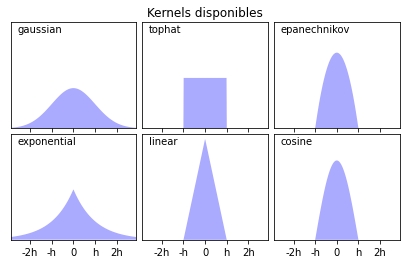

In [3]:
# Graficamos los kernels más utilizados
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x
    
for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Kernels disponibles")
plt.show()

Para comprender mejor el algoritmo de KDE, nos vamos a dirigir al siguiente enlace:

- [Artículo para ganar intuición acerca del método KDE (de Mathew Conlen)](https://mathisonian.github.io/kde/)

Luego de discutir acerca del método, utilizaremos KDE mediante la librería `sklearn`. Primero lo haremos 1D y luego 2D para ver cómo cambia.

## Caso 1D

Veamos un caso sencillo unidimensional, donde tenemos los datos provenientes de dos distribuciones gaussianas subyacentes, una centrada en 0 y otra en 5: 

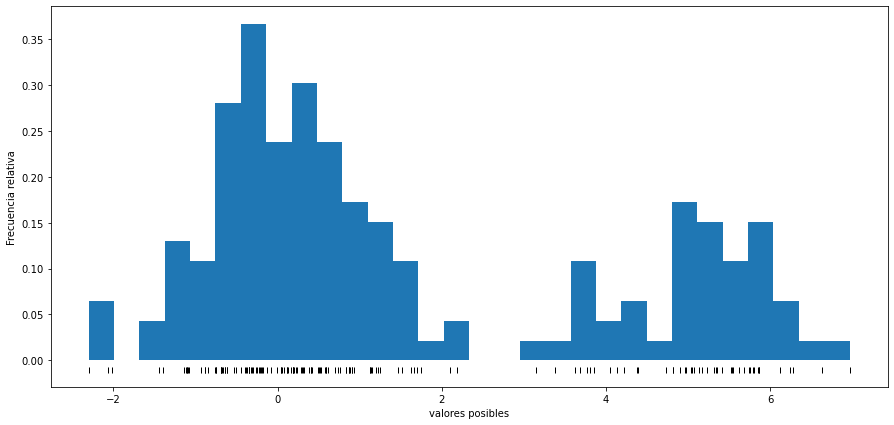

In [4]:
def crear_datos_1D(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = crear_datos_1D(150,f=0.7)

plt.figure(figsize=(15,7))
plt.hist(x, bins=30, density=True)
plt.xlabel('valores posibles')
plt.ylabel('Frecuencia relativa')
plt.plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)
plt.show()

Ahora generaremos el estimador de la densidad de kernel utilizando la clase `KernelDensity` de `sklearn`

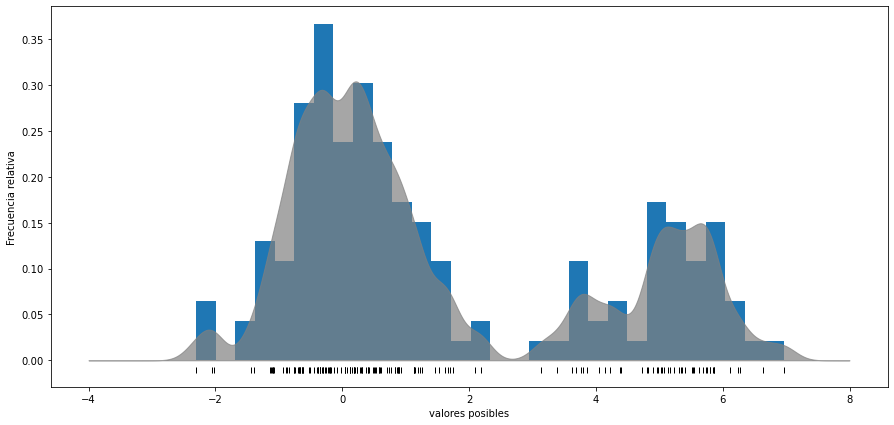

In [5]:
# Generamos el estimador de la densidad de probabilidad con KDE

kernel = 'gaussian'
bandwidth = 0.2

x_d = np.linspace(-4, 8, 1000)
kde = KernelDensity(bandwidth=bandwidth, kernel=kernel) 
kde.fit(x[:,None])
logprob = kde.score_samples(x_d[:, None]) #devuelve el logaritmo de la probabilidad

# Graficamos
plt.figure(figsize=(15,7))
plt.hist(x, bins=30, density=True)
plt.xlabel('valores posibles')
plt.ylabel('Frecuencia relativa')
plt.plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)
plt.fill_between(x_d, np.exp(logprob), alpha=0.7, color='gray', zorder=3)

plt.show()

## Caso 2D

La definición del estimador de densidad se puede extender a múltiples dimensiones de la siguiente manera

## $\hat{f_{\bf H}(x)} = \frac{1}{N |{\bf H}|^{1/2}}\sum_{i=1}^N K(\frac{{\bf x} - {\bf x}_i}{|{\bf H}|^{1/2}})$,

donde ${\bf x}$ y ${\bf x_i}$ son vectores de dimensión $d$, ${\bf H}$ es la matriz $d\times d$ de ancho de banda la cual es simétrica y definida positiva y $K$ es la función de kernel, la cuál es una densidad simétrica multivariada.

En particular, vamos a analizar un lindo ejemplo adaptado del libro [Python data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html) (Muy útil para leer, pero levemente desactualizado).

Vamos a utilizar datos provistos por `scikit-learn` acerca de la distribución geográfica de observaciones registradas de dos mamíferos sudamericanos: *Bradypus variegatus* (perezoso) y *Microryzomys minutus* (una ratita, roedor de la familia Cricetidae). Primero traemos los datos de sklearn:

In [6]:
data = fetch_species_distributions()

latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T

species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']],
                   dtype='int')

Hemos importado las coordenadas geográficas de las observaciones registradas en `latlon` y además hemos guardado la especie en `species`. Para graficar en un mapa, podemos utilizar la librería `cartopy`. El siguiente gráfico es a modo de ejemplo, no es necesario entender en profunidad cómo fue hecho.  

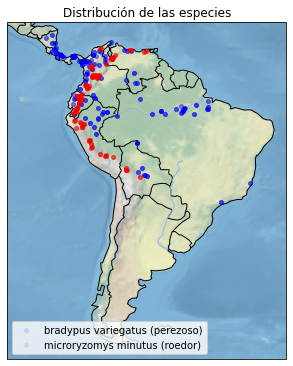

In [7]:
# Límites de la figura
lat_max, lat_min = latlon[:,0].max(), latlon[:,0].min()
lon_max, lon_min = latlon[:,1].max(), latlon[:,1].min()

# Comenzamos la figura
fig = plt.figure(figsize=(5,10))
# Especifico la proyección del mapa, necesaria para cartopy
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([lon_min*1.1, lon_max*0.8, lat_min*2.5, lat_max*1.2], crs=ccrs.PlateCarree())
# Agrego la imagen de fondo y características
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.RIVERS)

# Agrego los datos
ax.scatter(latlon[:, 1][species==0], latlon[:, 0][species==0], zorder=3,
           c='blue', alpha=0.1, s=15, label='bradypus variegatus (perezoso)')
ax.scatter(latlon[:, 1][species==1], latlon[:, 0][species==1], zorder=3,
           c='red', alpha=0.1, s=15, label='microryzomys minutus (roedor)')

plt.title('Distribución de las especies')
plt.legend()
plt.show()

Si nos quedamos únicamente con la información provista en este gráfico resulta difícil hacerse una buena idea de la distribución espacial de la densidad de estas especies ya que hay muchos puntos que se superponen. De hecho, se están mostrando más de 1600 puntos en este gráfico, lo cual a simple vista es difícil se observar. En este caso, resulta útil realizar una estimación de la densidad espacial de cada especie utilizando KDE bidimensional. En este caso, debido a que los datos se encuentran en la superficie de una esfera (transformación de coordenadas) en vez de en un plano, utilizaremos una métrica de distancia llamada `haversine`, la cuál interpretará correctamente la distancia sobre la superficie terrestre entre dos puntos dados por latitud y longitud.  

In [8]:
# Hacemos la grilla de puntos sobre la cuál vamos a hacer el gráfico de contorno. 
# Como estos datos se encuentran en batches (porciones), entonces debe ser hecho de una manera particular
# No es necesario entender esto, pero es necesario correrlo para ver los siguientes gráficos

def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])

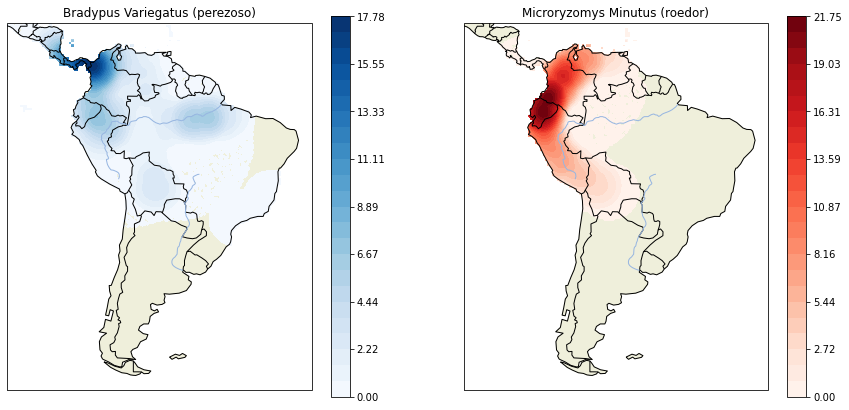

In [9]:
# Hiperparámetros de KDE
kernel = 'epanechnikov' #ver diferencia con kernel gaussiano 'gaussian'
bandwidth = 0.1

# Lo siguiente es necesario para obtener un muestreo de los xy en radianes. No es necesario entenderlo.
land_reference = data.coverages[6][::5, ::5] #
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Definimos los nombres de las especies
species_names = ['Bradypus Variegatus (perezoso)', 'Microryzomys Minutus (roedor)']

#comenzamos la figura
plt.figure(figsize=(15,7))
for i in range(2):
    # vamos a hacer dos subplots
    plt.subplot(1, 2, i+1, projection=ccrs.PlateCarree())
    # gca = get current axis
    axi = plt.gca()
    axi.set_title(species_names[i])
    axi.set_extent([lon_min*1.1, lon_max*0.8, lat_min*2.5, lat_max*1.2], crs=ccrs.PlateCarree())

    # axi.stock_img()  #Descomentar si se quiere ver la imagen de fondo
    axi.add_feature(cfeature.LAND)
    axi.add_feature(cfeature.COASTLINE)
    axi.add_feature(cfeature.BORDERS)
    axi.add_feature(cfeature.RIVERS)
    
    # generamos el estimador de la densidad de kernel con corrección esférica
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel, metric='haversine')
    
    kde.fit(np.radians(latlon[species == i]))

    # Evaluamos el estimador sólo en la tierra: -9999 indica mar
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    # Graficamos los contornos de densidad
    levels = np.linspace(0, Z.max(), 25)
    if i==0:
        Z1 = Z
        cs = axi.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Blues)
    else:
        Z2 = Z
        cs = axi.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.colorbar(cs)
plt.show()

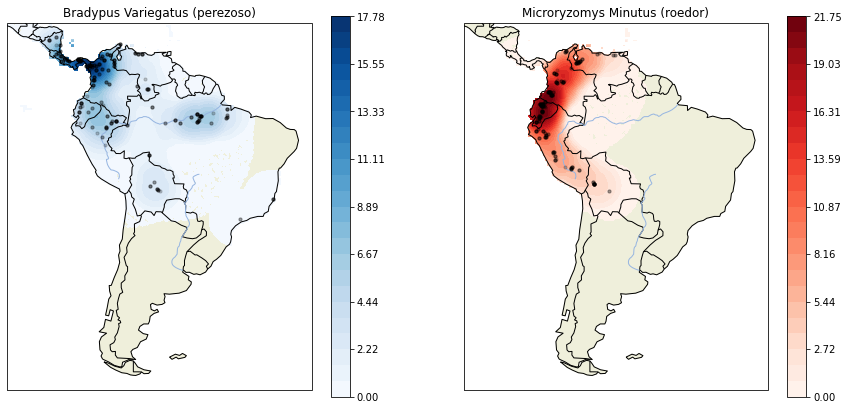

In [10]:
Xtest = np.vstack([data["test"]["dd lat"], data["test"]["dd long"]]).T
ytest = np.array(
    [d.decode("ascii").startswith("micro") for d in data["test"]["species"]],
    dtype="int",
)


plt.figure(figsize=(15,7))
for i in range(2):
    plt.subplot(1, 2, i+1, projection=ccrs.PlateCarree())
    axi = plt.gca()
    axi.set_title(species_names[i])
    axi.set_extent([lon_min*1.1, lon_max*0.8, lat_min*2.5, lat_max*1.2], crs=ccrs.PlateCarree())
    # axi.stock_img()

    axi.add_feature(cfeature.LAND)
    axi.add_feature(cfeature.COASTLINE)
    axi.add_feature(cfeature.BORDERS)
    axi.add_feature(cfeature.RIVERS)

    
    
    # Probamos con test
    if i==0:
        axi.scatter(Xtest[:, 1][ytest==0], Xtest[:, 0][ytest==0], zorder=3,
           c='black', alpha=0.2, s=10)
        # plot contours of the density
        levels = np.linspace(0, Z1.max(), 25)
        cs = axi.contourf(X, Y, Z1, levels=levels, cmap=plt.cm.Blues)
    else:
        axi.scatter(Xtest[:, 1][ytest==1], Xtest[:, 0][ytest==1], zorder=3,
            c='black', alpha=0.2, s=10)
        # plot contours of the density
        levels = np.linspace(0, Z2.max(), 25)
        cs = axi.contourf(X, Y, Z2, levels=levels, cmap=plt.cm.Reds)
    plt.colorbar(cs)

plt.show()

Ejemplo no muy útil en este caso de cómo visualizar un gráfico en 3D:

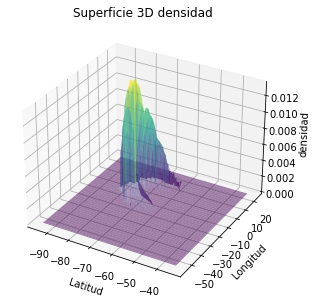

In [11]:
from mpl_toolkits.mplot3d import axes3d
Z3 = Z2.copy()
Z3[Z2==-9999] = 0

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
#ax.view_init(60, 35)
ax.plot_surface(X, Y, Z3/latlon.shape[0], cmap='viridis', alpha=0.5)
ax.set_xlabel('Latitud')
ax.set_ylabel('Longitud')
ax.set_zlabel('densidad')
ax.set_title('Superficie 3D densidad')

plt.show()

# Bilbiografía y recursos útiles:

- [Simple 1D Kernel Density Estimation in sklearn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py)

- [Ajuste de distribuciones con kernel density estimation y Python de Joaquin Amat Rodrigo](https://www.cienciadedatos.net/documentos/pystats02-kernel-density-estimation-kde-python.html)

- [Artículo para ganar intuición acerca del método KDE de Mathew Conlen](https://mathisonian.github.io/kde/)